In [88]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.src.layers import Dropout, Dense, Activation, Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.src.layers import Conv1D
from keras import Sequential
from keras.src.utils import pad_sequences
from keras.src.legacy.preprocessing.text import Tokenizer
import keras

In [ ]:
pd.set_option('display.max_colwidth', 100)
data = pd.read_csv("train.tsv", sep="\t", on_bad_lines='skip')

In [89]:
data.columns = ["label", "text"]
data['text_clean'] = data['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
data.head()

,label,text,text_clean
0,1,Przyjmujący reprezentacji Polski wrócił do PGE Skry Bełchatów Tylko rok trwał rozbrat Artura Sza...,"[przyjmujący, reprezentacji, polski, wrócił, do, pge, skry, bełchatów, tylko, rok, trwał, rozbra..."
1,0,FEN 9: Zapowiedź walki Róża Gumienna vs Katarzyna Posiadała (wideo) Podczas Fight Exclusive Nigh...,"[fen, zapowiedź, walki, róża, gumienna, vs, katarzyna, posiadała, wideo, podczas, fight, exclusi..."
2,1,Aleksander Filipiak: Czuję się dobrze w nowym klubie Aleksander Filipiak w przerwie letniej zami...,"[aleksander, filipiak, czuję, się, dobrze, nowym, klubie, aleksander, filipiak, przerwie, letnie..."
3,0,Victoria Carl i Aleksiej Czerwotkin mistrzami świata juniorów na 5 i 10 kilometrów Biegi na 5 i ...,"[victoria, carl, aleksiej, czerwotkin, mistrzami, świata, juniorów, na, kilometrów, biegi, na, k..."
4,1,Świat poznał ją na mundialu. Francuska WAG czaruje pięknym ciałem Rachel Legrain-Trapani to jedn...,"[świat, poznał, ją, na, mundialu, francuska, wag, czaruje, pięknym, ciałem, rachel, legrain, tra..."


In [24]:
w2v_model = gensim.models.Word2Vec(data["text_clean"],
                                   vector_size=500,
                                   window=5,
                                   min_count=2,
                                   workers=4)

In [55]:
token = Tokenizer(7229)
token.fit_on_texts(data['text_clean'])
text = token.texts_to_sequences(data['text_clean'])
text = pad_sequences(text, 75)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(text), data['label'], test_size=0.2)
X_train

array([[   0,    0,    0, ...,    2,   20, 1957],
       [   0,    0,    0, ..., 7153,  441,  292],
       [   0,    0,    0, ..., 3702, 2385,    9],
       ...,
       [   0,    0,    0, ...,  520, 1094, 3132],
       [   0,    0,    0, ...,   44,  287, 1800],
       [   0,    0,    0, ...,  160,   57,  187]])

In [12]:
vocab_size = len(token.word_index) + 1

In [26]:
embedding_matrix = np.zeros((vocab_size, 500))
for word, i in token.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [27]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [28]:
keras_model = Sequential()
keras_model.add(Embedding(vocab_size, 500, weights=[embedding_matrix], trainable=False))
keras_model.add(Dropout(0.4))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPooling1D())
keras_model.add(Dropout(0.4))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPooling1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPooling1D())
keras_model.add(Dropout(0.4))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.4))
keras_model.add(Dense(1))
keras_model.add(Activation('sigmoid'))
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=opt)
keras_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - acc: 0.9434 - loss: 0.1327 - val_acc: 0.9795 - val_loss: 0.0647
Epoch 2/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - acc: 0.9801 - loss: 0.0614 - val_acc: 0.9798 - val_loss: 0.0675
Epoch 3/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - acc: 0.9831 - loss: 0.0532 - val_acc: 0.9822 - val_loss: 0.0542
Epoch 4/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - acc: 0.9851 - loss: 0.0455 - val_acc: 0.9832 - val_loss: 0.0502
Epoch 5/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - acc: 0.9850 - loss: 0.0458 - val_acc: 0.9803 - val_loss: 0.0574
Epoch 6/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - acc: 0.9860 - loss: 0.0419 - val_acc: 0.9836 - val_loss: 0.0552
Epoch 7/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - acc: 0.9862 - loss: 0.0395 - val_acc: 0.9830 - val_loss: 0.0646
Epoch 8/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - acc: 0.9874 - loss: 0.0362 - val_acc: 0.9787 - val_loss: 0.0723
Epoch 9/10
1227/1227 ━━━

In [29]:
model = keras_model

In [56]:
def preprocess(path):
    data = pd.read_csv(path, sep="\t", on_bad_lines='skip')
    data.columns = ["text"]
    data['text_clean'] = data['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
    text = token.texts_to_sequences(data['text_clean'])
    text = pad_sequences(text, 75)
    return text

Get threshold

In [45]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import confusion_matrix as cm_sklearn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def plot_discrimination_threshold(clf, X_test, y_test, argmax='f1', title='Metrics vs Discriminant Threshold', fig_size=(10, 8), dpi=100, save_fig_path=None):
    """
    Plot precision, recall and f1-score vs discriminant threshold for the given pipeline model
    Parameters
    ----------
    clf : estimator instance (either sklearn.Pipeline, imblearn.Pipeline or a classifier)
        PRE-FITTED classifier or a PRE-FITTED Pipeline in which the last estimator is a classifier.
    X_test : pandas.DataFrame of shape (n_samples, n_features)
        Test features.
    y_test : pandas.Series of shape (n_samples,)
        Target values.
    argmax : str, default: 'f1'
        Annotate the threshold maximized by the supplied metric. Options: 'f1', 'precision', 'recall'
    title : str, default ='FPR and FNR vs Discriminant Threshold'
        Plot title.
    fig_size : tuple, default = (10, 8)
        Size (inches) of the plot.
    dpi : int, default = 100
        Image DPI.
    save_fig_path : str, defaut=None
        Full path where to save the plot. Will generate the folders if they don't exist already.
    Returns
    -------
        fig : Matplotlib.pyplot.Figure
            Figure from matplotlib
        ax : Matplotlib.pyplot.Axe
            Axe object from matplotlib
    """
        
    thresholds = np.linspace(0, 1, 100)
    
    precision_ls = []
    recall_ls = []
    f1_ls = []
    fpr_ls = []
    fnr_ls = []
    
    # obtain probabilities
    probs = clf.predict(X_test)

    for threshold in thresholds:   
    
        # obtain class prediction based on threshold
        y_predictions = np.where(probs>=threshold, 1, 0) 
        
        # obtain confusion matrix
        tn, fp, fn, tp = cm_sklearn(y_test, y_predictions).ravel()
        
        # obtain FRP and FNR
        FPR = fp / (tn + fp)
        FNR = fn / (tp + fn)
        
        # obtain precision, recall and f1 scores
        precision = precision_score(y_test, y_predictions, average='binary')
        recall = recall_score(y_test, y_predictions, average='binary')
        f1 = f1_score(y_test, y_predictions, average='binary')
         
        precision_ls.append(precision)
        recall_ls.append(recall)
        f1_ls.append(f1)
        fpr_ls.append(FPR)
        fnr_ls.append(FNR)
              
    metrics = pd.concat([
        pd.Series(precision_ls),
        pd.Series(recall_ls),
        pd.Series(f1_ls),
        pd.Series(fpr_ls),
        pd.Series(fnr_ls)], axis=1)

    metrics.columns = ['precision', 'recall', 'f1', 'fpr', 'fnr']
    metrics.index = thresholds
    
    plt.rcParams["figure.facecolor"] = 'white'
    plt.rcParams["axes.facecolor"] = 'white'
    plt.rcParams["savefig.facecolor"] = 'white'
                
    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
    ax.plot(metrics['precision'], label='Precision')
    ax.plot(metrics['recall'], label='Recall')
    ax.plot(metrics['f1'], label='f1')
    ax.plot(metrics['fpr'], label='False Positive Rate (FPR)', linestyle='dotted')
    ax.plot(metrics['fnr'], label='False Negative Rate (FNR)', linestyle='dotted')
    
    # Draw a threshold line
    disc_threshold = round(metrics[argmax].idxmax(), 2)
    ax.axvline(x=metrics[argmax].idxmax(), color='black', linestyle='dashed', label="$t_r$="+str(disc_threshold))

    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_formatter('{x:.1f}')
    
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_formatter('{x:.1f}')

    ax.xaxis.set_minor_locator(MultipleLocator(0.05))    
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))    

    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4, color='black') 
    
    plt.grid(True)
    
    plt.xlabel('Probability Threshold', fontsize=18)
    plt.ylabel('Scores', fontsize=18)
    plt.title(title, fontsize=18)
    leg = ax.legend(loc='best', frameon=True, framealpha=0.7)
    leg_frame = leg.get_frame()
    leg_frame.set_color('gold')
    plt.show()

    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path, dpi=dpi)

    return fig, ax, disc_threshold

614/614 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


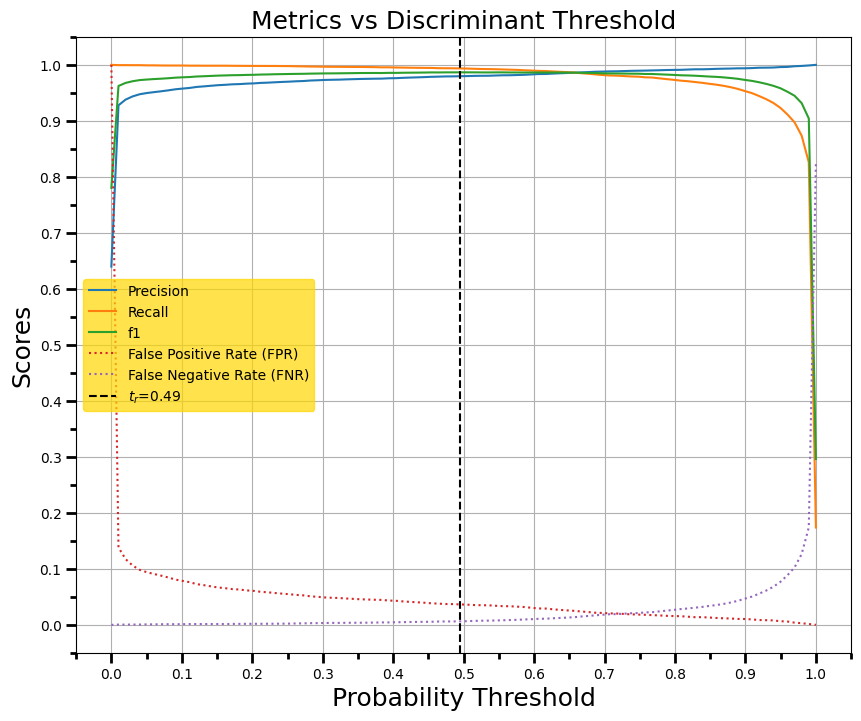

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Metrics vs Discriminant Threshold'}, xlabel='Probability Threshold', ylabel='Scores'>,
 0.49)

In [46]:
plot_discrimination_threshold(model,X_test, y_test)

## TEST-A

In [ ]:
x = preprocess("test-A/in.tsv")
res = model.predict(x)
y_predictions = np.where(res >= 0.49, 1, 0)
out = pd.DataFrame(y_predictions)
out.to_csv('out.tsv', sep="\t", index=False)

## DEV-0

In [63]:
x = preprocess("dev-0/in.tsv")
res = model.predict(x)
y_predictions = np.where(res >= 0.49, 1, 0)
out = pd.DataFrame(y_predictions)
out.to_csv('dev-0/out.tsv', sep="\t", index=False) 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [67]:
from sklearn.metrics import accuracy_score
y = pd.read_csv("./dev-0/expected.tsv")
score = accuracy_score(y_true=y, y_pred=out)

In [87]:
score

0.9814712896716199

In [85]:
import math

points = math.ceil(score * 7.0)

In [86]:
points

7